# Load library

In [60]:
import requests # send request to website
from bs4 import BeautifulSoup as bs # convert the web content to bs object
from bs4 import Comment # search if we are caught by Amazon as a robot
from fake_useragent import UserAgent #create fake user agent from different browser
import re # regular expression
import pandas as pd # output dataframe
import numpy as np # fast data manipulation
import random # randomly use agent header for sending request
import time #If access is denied, sleep 5s and then request again
from collections import defaultdict #Used to declare a dictionary with emply 
print(requests.__version__)
import os
import csv
from string import punctuation

2.28.1


# How to create headers for request
1. Some Tutorials I used:
    - https://www.crummy.com/software/BeautifulSoup/bs4/doc/#comments-and-other-special-strings
    - https://www.blog.datahut.co/post/web-scraping-best-practices-tips
    - https://stackoverflow.com/questions/63305902/why-cant-i-scrape-amazon-products-by-beautifulsoup
    - https://www.digitalocean.com/community/tutorials/scrape-amazon-product-information-beautiful-soup
    - https://stackoverflow.com/questions/63615686/how-to-scrape-data-from-amazon-canada
    - https://stackoverflow.com/questions/33138937/how-to-find-all-comments-with-beautiful-soup
    - https://pypi.org/project/fake-useragent/
    - https://github.com/jhnwr/scrape-amazon-reviews/blob/main/review-scraper.py
    - https://www.fullstaxx.com/2021/05/23/multipage-scraping-amazon-python/
    - https://github.com/sergioteula/python-amazon-paapi
    
2. Depends on where Amazon location you are scraping, you need to use different headers. The following are just 2 examples:

    - For Amazon Canada: you use:

    `headers = {
        'content-type': 'text/html;charset=UTF-8',
        'Accept-Encoding': 'gzip, deflate, sdch',
        'Accept-Language': 'en-US,en;q=0.8',
        'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    }`

    - For Amazon Indian, you use:

    `headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.89 Safari/537.36'}`

    - For Amazon UK, you use:
    
    `headers = {
    'User-Agent':'Mozilla/5.0 (Windows; U; Windows NT 6.0; en-US; rv:1.8.0.8) Gecko/20061025 Firefox/1.5.0.8'}`
    
    
3. Here is a list of User-Agent strings for different browsers: https://www.useragentstring.com/pages/useragentstring.php
4. I will use fake-useragent (pip3 install fake-useragent)to generate a list of fake user agent.

# Fetch data from individual website using a list of fake User Agent to disguise our IP

In [58]:
#Create a class to deal with web request and convert it to beautiful soup
class get_soup:
    header = None
    #When the class is initiated, a list of user agent will be generated
    '''
    There is a pretty useful third-party package called fake-useragent 
    that provides a nice abstraction layer over user agents: https://pypi.org/project/fake-useragent/

    If you don't want to use the local data, you can use the external data source to retrieve the user-agents. 
    #Set use_external_data to True:
    '''
    def __init__(self, total_user_agent = 1000):
        ua = UserAgent(browsers=["chrome", "edge", "internet explorer", "firefox", "safari", "opera"])
        # I will generate a lsit of fake agent string with total number of total_user_agent
        self.user_agent_set = set()
        # Set a cap for user_agent_set to prevent endless loop
        while(len(self.user_agent_set)<total_user_agent and len(self.user_agent_set) < 4500):
            self.user_agent_set.add(ua.random)
    '''
    Define the function to get contents from each page. 
    Each header_attempts will use the same header until it is caught by the weg server.
    In each header_attempts, we will try request_attempts times to request contents until we get the right contents
    '''
    def get_individual_soup(self, url, header_attempts = 10, request_attempts = 10):
        self.soup = 'No Data Returned'
        for _ in range(header_attempts):
            request_count = 0
            page = ''
            notDenied = True
            # We want to keep using the same header if that one particular header is working
            # We change it unless it is recognized and banned by Web server
            if get_soup.header is None:
                user_agent = random.choice(list(self.user_agent_set))
                get_soup.header = {'content-type': 'text/html;charset=UTF-8',
                'Accept-Encoding': 'gzip, deflate, sdch',
                'Accept-Language': 'en-US,en;q=0.8',
                'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
                "User-Agent": user_agent}

            while page == '' and request_count < request_attempts and notDenied:
                try:
                    request_count += 1
                    page = requests.get(url, headers=get_soup.header, timeout=10)
                    self.soup = bs(page.content, "lxml")
                    '''If the page returns a message like To discuss automated access 
                        to Amazon data please contact api-services-support@amazon.com.
                        We know we are denied access to the web page.
                        Or,
                        Amazon page blocks you by returning a login page
                        In either case, lets try again using different header
                    '''
                    comments = self.soup.find_all(string=lambda text: isinstance(text, Comment))
                    login_page = self.soup.find('a', id = 'createAccountSubmit', class_ = 'a-button-text')                    
                    for comment in comments:
                        if ("api-services-support@amazon.com" in comment) or login_page:
                            notDenied = False
                            get_soup.header = None
                            self.soup = 'No Data Returned'
                            break
                            
                    if (notDenied):
                        return self.soup
                    #We are caught by Web server as a bot, break this while and try a new header
                    break
                except:
                    get_soup.header = None
                    print("Connection refused by the server..")
                    print("Let me sleep for 5 seconds")
                    time.sleep(5)
                    print("Now I will use a different header to request data...")
                    #The server does not respond to our request, break this while and try a new header
                    break
        return self.soup
    '''
    Customer Reviews, including Product Star Ratings, 
    help customers to learn more about the product and decide whether it is the right product for them.
    To calculate the overall star rating and percentage breakdown by star, we don’t use a simple average. 
    Instead, our system considers things like how recent a review is and if the reviewer bought the item on Amazon. 
    It also analyses reviews to verify trustworthiness.
    Learn more from
    https://www.amazon.co.uk/gp/help/customer/display.html/ref=cm_cr_arp_d_omni_lm_btn?nodeId=G8UYX7LALQC8V9KA'''
    #Define a function to get the review of a product on one page only
    def get_page_reviews(self, ASIN, soup = None):
        reviewlist = []
        if soup is not None:
            for item in soup.find_all('div', {'data-hook': 'review'}):
                try:
                    #This is domenstic review
                    review = {
                                'ASIN': ASIN,
                                'product Name': soup.title.text.replace('Amazon.co.uk:Customer reviews:', '').strip(),
                                'Review Title': item.find('a', {'data-hook': 'review-title'}).get_text().strip(),
                                'Review Rating':  float(item.find('i', {'data-hook': 'review-star-rating'}).get_text().replace('out of 5 stars', '').strip()),
                                'Review Body': item.find('span', {'data-hook': 'review-body'}).get_text().strip(),
                                'Review Date': item.find('span', {'data-hook': 'review-date'}).get_text().strip(),
                                }
                except AttributeError:
                    #This is international review
                    try:
                        review = {
                                'ASIN': ASIN,
                                'product Name': soup.title.text.replace('Amazon.co.uk:Customer reviews:', '').strip(),
                                'Review Title': item.find('span', {'data-hook': 'review-title'}).get_text().strip(),
                                'Review Rating':  float(item.find('i', {'data-hook': 'cmps-review-star-rating'}).get_text().replace('out of 5 stars', '').strip()),
                                'Review Body': item.find('span', {'data-hook': 'review-body'}).get_text().strip(),
                                'Review Date': item.find('span', {'data-hook': 'review-date'}).get_text().strip(),
                                }
                    except:
                        #If there is still error, return None
                        review = {
                                'ASIN': None,
                                'product Name': None,
                                'Review Title': None,
                                'Review Rating': None,
                                'Review Body': None,
                                'Review Date': None,
                                }
                reviewlist.append(review)
        return reviewlist

#Create a class to handle all the file I/O
class Review_file_io:
    '''
    This method is to get the root link for each product
    '''
    @classmethod
    def get_review_link(cls, file_loc):
        #Get the review entrance link for all the product items
        review_links = {}
        with open (file_loc, mode = "r") as f:
            for link in f:
                entry_link = link.strip().split(",")[0]
                if (not re.search("product-reviews/.*/ref", entry_link)):
                    continue
                ASIN = re.search("product-reviews/.*/ref", entry_link).group(0).split("/")[1]
                '''Need to think this again, this is mainly for empty page loc'''
                if re.search(r'&pageNumber=\d+$', entry_link):
                    review_links[ASIN] = entry_link
                else:
                    review_links[ASIN] = entry_link + "&pageNumber="
        return review_links
    '''
    This method is to get all the reviews on every page of a product
    '''
    def get_product_reviews(self, file_loc, reviews_loc, empty_page_loc, total_page = 999, header_attempts = 3, request_attempts = 1):
        review_links = Review_file_io.get_review_link(file_loc)
        mySoup = get_soup()
        empty_page = defaultdict(list)
        reviews = []
        #loop through each page and get reviews on each page
        for ASIN, review_link in review_links.items():
            for page_number in range(1,total_page):
                print(f"You are on product {ASIN} page {page_number}")
                page_url = f"{review_link}{page_number}"
                page_soup = mySoup.get_individual_soup(page_url,header_attempts = header_attempts, request_attempts = request_attempts)
                '''
                There are 3 cases page_soup equals 'No Data Returned'.
                1st is when you get caught by Amazon as a bot;
                2nd is Amazon returns you a login page
                3rd is when our scrapper has tried header_attempts*request_attempts times to reach the page,
                    but still got nothing, either rejected or caught by the server;

                There are case that you do get the page content from our web scrapper,
                but there are no reviews on that page. For example, 
                1. You get the page, but the page 
                2. you hit the last review page;
                3. the product item just does not have any reviews at all.
                '''
                if page_soup != 'No Data Returned':
                    review = mySoup.get_page_reviews(ASIN, page_soup)
                    #There are simply no reviews for this product item, there are 2 things can happen:
                    #1st: the review page is just some random page returned by Amazon
                    #2nd: the review page is a normal review page but 
                        #because the page number has gone out of bound, there is simply no review at all
                    if not review:
                        #this is is to check if the page is a normal review page but the page number is out of boundary
                        #The first find is to check if the page still has product title
                        #The second find is to check if there is no Previous Page or Next Page button, that means this is it, there is no more reviews to look, break it
                        #what is inside this tag is: '←Previous pageNext page→'
                        if page_soup.find("a", attrs={"data-hook": "product-link"}) and not page_soup.find("ul", {'class': 'a-pagination'}):
                            break
                        continue
                        
                    reviews.extend(review)

                    #if not page_soup.find("ul", {'class': 'a-pagination'}):
                        #break
                    #Last page is hit, we break the for loop
                    if page_soup.find('li', {'class': 'a-disabled a-last'}):
                        break
                    else:
                        continue
                #When we failed to get the content for this page, record this page, and go to the next page
                else:
                    empty_page[ASIN].append(page_url)
                    continue
        #Save the reviews and empty page link
        try:
            with open (reviews_loc, mode = "a") as f:
                csv_columns = ['ASIN', 'product Name', 'Review Title', 'Review Rating', 'Review Body', 'Review Date']
                writer = csv.DictWriter(f, fieldnames=csv_columns)
                writer.writeheader()
                for prod_info in reviews:
                    writer.writerow(prod_info)

            with open (empty_page_loc, mode = "a") as f:
                writer = csv.writer(f)
                writer.writerow(['URLs', 'ASIN'])
                for key, page in empty_page.items():
                    for link in page:
                        writer.writerow([link, key])
        except:
            print("I/O error")
    

# Example how you can iterate through each page to get the item link

In [3]:
# Get the link for each product in the home page
mySoup = get_soup()
#Grab the item link from each page and save them in a text file
item_link = []
# root_url = "https://www.amazon.ca/s?k=headphones&i=electronics&page="
# root_url = "https://www.amazon.in/s?k=headphones&page="
root_url = "https://www.amazon.co.uk/s?k=headphones&i=electronics&s=review-rank&page="

for page_number in range(200,250):
    print(f"You are on page {page_number}")
    home_soup = mySoup.get_individual_soup(root_url+str(page_number),
                                          header_attempts = 2, request_attempts = 1)
    #If there is nothing return from the website, go to next page
    if home_soup != 'No Data Returned':
        if (mySoup.header is not None):
            print("You are using " + mySoup.header["User-Agent"] + " to retrieve data")
    else:
        print(f"No data returned. You are using `{mySoup.header}` to retrieve data")
        continue
    for link in home_soup.select("h2 a.a-link-normal.s-underline-text.s-underline-link-text.s-link-style"):
        item_link.append(link['href'])

with open ("./Dataset/partial items link CA7.txt", mode = "wt") as f:
    for link in item_link:
        f.write(link+"\n\n")

You are on page 200
You are using Mozilla/4.0 (compatible; MSIE 5.5b1; Mac_PowerPC) to retrieve data
You are on page 201
You are using Mozilla/4.0 (compatible; MSIE 5.5b1; Mac_PowerPC) to retrieve data
You are on page 202
You are using Mozilla/4.0 (compatible; MSIE 5.5b1; Mac_PowerPC) to retrieve data
You are on page 203
You are using Mozilla/4.0 (compatible; MSIE 5.5b1; Mac_PowerPC) to retrieve data
You are on page 204
You are using Mozilla/4.0 (compatible; MSIE 5.5b1; Mac_PowerPC) to retrieve data
You are on page 205
You are using Mozilla/4.0 (compatible; MSIE 5.5b1; Mac_PowerPC) to retrieve data
You are on page 206
You are using Mozilla/4.0 (compatible; MSIE 5.5b1; Mac_PowerPC) to retrieve data
You are on page 207
You are using Mozilla/4.0 (compatible; MSIE 5.5b1; Mac_PowerPC) to retrieve data
You are on page 208
You are using Mozilla/4.0 (compatible; MSIE 5.5b1; Mac_PowerPC) to retrieve data
You are on page 209
You are using Mozilla/4.0 (compatible; MSIE 5.5b1; Mac_PowerPC) to retr

# Generate a csv of links to each of those items, the price and the #of reviews From Stu

In [4]:
# Initiate a new soup object
mySoup = get_soup()

# home_soup = mySoup.get_individual_soup(root_url+str(page_number),
#                                           header_attempts = 2, request_attempts = 1)

linklist = []
duplicates = []
Skipped_pages = []
for x in range(2,10):
    soup = mySoup.get_individual_soup(f'https://www.amazon.co.uk/s?k=heaphones&page={x}',
                                          header_attempts = 2, request_attempts = 1)
    
    #If there is nothing return from the website, go to next page
    if soup != 'No Data Returned':
        for link in soup.find_all('a', href=True):
            href = link['href']
            if 'keywords=heaphones' in href:
                if 'offer-listing' not in href:
                    if '#customerReviews' not in href:
                        duplicates.append(href)
    else:
        print(f"No data returned. You are using `{mySoup.header}` to retrieve data")
        Skipped_pages.append(x)
        continue

duplicates = [x.split('/ref')[0] for x in duplicates]
duplicates = [x.split('?keywords')[0] for x in duplicates]
for i in duplicates:
    # Add to the new list
    # only if not present
    if i not in linklist:
        linklist.append(i)

finalList = ['https://www.amazon.co.uk' + s for s in linklist]

In [5]:
price = []
for x in finalList:
    soup = mySoup.get_individual_soup(x, header_attempts = 2, request_attempts = 1)
    spans = soup.find('span', attrs = {'class' : 'a-price-whole'})
    if spans == None:
        price.append('')
    else:
        price.append(spans.text.strip(punctuation))

In [6]:
review = []
for x in finalList:
    soup = mySoup.get_individual_soup(x, header_attempts = 2, request_attempts = 1)
    spans = soup.find('span',id ="acrCustomerReviewText", attrs = {'class' : 'a-size-base'})
    if spans == None:
        review.append('')
    else:
        review.append(spans.text.strip(punctuation))

finalList

['https://www.amazon.co.uk/Apple-EarPods-with-Lightning-Connector/dp/B01M1EEPOB',
 'https://www.amazon.co.uk/Sony-WH-1000XM3-Wireless-Cancelling-Headphones-Black/dp/B07GDR2LYK',
 'https://www.amazon.co.uk/Earphones-Blukar-Headphones-Sensitivity-Microphone-Silver/dp/B07QLWMDLC',
 'https://www.amazon.co.uk/JVC-HA-L50-B-E-Lightweight-Headphones-Black/dp/B000I2J4S4',
 'https://www.amazon.co.uk/Sony-MDR-ZX310AP-Foldable-Headphones-Smartphone-Metallic-Red/dp/B00I3LV3EU',
 'https://www.amazon.co.uk/EarFun-Wireless-Bluetooth-Detection-Headphones-Matte-Black/dp/B088H7GMHZ',
 'https://www.amazon.co.uk/Sony-MDR-EX15AP-Earphones-Smartphone-Control-Black/dp/B00I3LV1HE',
 'https://www.amazon.co.uk/Betron-AX5-Headphones-Microphone-Smartphones-Black-Gold/dp/B0786S43W4',
 'https://www.amazon.co.uk/JVC-Headphones-Earphones-Compatible-Samsung-Black/dp/B00ZAT03S0',
 'https://www.amazon.co.uk/Isolating-Headphones-Microphone-Lightweight-Earphones/dp/B083J88QRS',
 'https://www.amazon.co.uk/OneOdio-Bluetooth-

In [7]:
headers = ['URLs', 'Price', '#Ratings']

finalList = [s+ '/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews' for s in finalList]
finalList = [s.replace("/dp/", "/product-reviews/") for s in finalList]

with open('links.csv', 'w', newline='') as csvfile:
    file_is_empty = os.stat('links.csv').st_size == 0
    writer = csv.writer(csvfile)
    if file_is_empty:
        writer.writerow(headers)
    writer.writerows(zip(finalList, price, review))

# Extract product information from multiple product items
There are a few product information we can get from a single product item.

- Product Name
- Review Title
- Review Rating
- Review Body
- Review Date

Because each product has many pages of reviews and each product takes quite some time, I split the links.csv file to smaller files. Each file has about 35 links in there, and I will need other team members to work separately to reduce running time. https://phoenixnap.com/kb/linux-split#:~:text=The%20Linux%20split%20command%20breaks,Linux%20split%20command%20with%20examples.&text=Access%20to%20the%20terminal%20line.

In [207]:
# my_review = Review_file_io()
# # my_review.get_review_link('./Dataset/Sample_link.csv')
# my_review.get_product_reviews('./Dataset/Yong/best_seller_headphone_link.csv', './Dataset/Yong/best_review.csv', './Dataset/Yong/best_empty_link.csv', total_page = 200,
#                              header_attempts=3, request_attempts=1)

'''
Concatnate multiple csv and remove duplicates, write to a parquet file
'''
lu_review = pd.read_csv("./Dataset/Yong/review2.csv")
total_review = pd.read_parquet("./Dataset/AmazonReviews.parquet")
AmazonReviews = pd.concat([total_review, lu_review], ignore_index=True)
AmazonReviews.drop_duplicates().astype(str).to_parquet('./Dataset/AmazonReviews2.parquet')

#The following is used to get Amazon Product Price informaiton
link1 = pd.read_csv("./Dataset/links.csv")
link2 = pd.read_csv("./Dataset/links2.csv")
link1['ASIN'] = link1.apply(lambda x: re.search("product-reviews/.*/ref", x['URLs']).group(0).split("/")[1], axis=1)
link2['ASIN'] = link2.apply(lambda x: re.search("product-reviews/.*/ref", x['URLs']).group(0).split("/")[1], axis=1)
AmazonProductPrice = pd.concat([link1, link2], ignore_index=True).drop_duplicates(subset="ASIN")
AmazonProductPrice.to_csv('./Dataset/AmazonProductPrice.csv', index = False)

# Extract home page information from best seller headphone pages
There are a few product information we can get from a single product item.

- ASIN
- Product Name
- Product Link
- Product Rank
- Product Price (if any)
- Product total reviews

I am only looking at the best seller headphone pages so that we can compare other headphones with them.
There are only two pages to look at: 

- 'https://www.amazon.co.uk/Best-Sellers-Electronics-Photo-Headphones-Earphones/zgbs/electronics/4085731/ref=zg_bs_pg_2?_encoding=UTF8&pg=2'
- 'https://www.amazon.co.uk/gp/bestsellers/electronics/4085731?ref_=Oct_d_obs_S&pd_rd_w=GN87T&content-id=amzn1.sym.6b376e0b-c3fa-4b95-b5c3-82d50c091b51&pf_rd_p=6b376e0b-c3fa-4b95-b5c3-82d50c091b51&pf_rd_r=04E83P9GTV047MBCJ2D8&pd_rd_wg=CKOyq&pd_rd_r=49c2d810-4b2c-4618-a164-7ed75ea5606a'

In [199]:
best_seller_headphone_homepage = ['https://www.amazon.co.uk/Best-Sellers-Electronics-Photo-Headphones-Earphones/zgbs/electronics/4085731/ref=zg_bs_pg_2?_encoding=UTF8&pg=2',
                                 'https://www.amazon.co.uk/gp/bestsellers/electronics/4085731?ref_=Oct_d_obs_S&pd_rd_w=GN87T&content-id=amzn1.sym.6b376e0b-c3fa-4b95-b5c3-82d50c091b51&pf_rd_p=6b376e0b-c3fa-4b95-b5c3-82d50c091b51&pf_rd_r=04E83P9GTV047MBCJ2D8&pd_rd_wg=CKOyq&pd_rd_r=49c2d810-4b2c-4618-a164-7ed75ea5606a']
mySoup = get_soup()
first_page = mySoup.get_individual_soup(best_seller_headphone_homepage[0],header_attempts = 3, request_attempts = 1)
second_page = mySoup.get_individual_soup(best_seller_headphone_homepage[1],header_attempts = 3, request_attempts = 1)

best_seller_headphone_homepage_list=[]
for i, title in enumerate(second_page.find_all("a", class_ = "a-link-normal")):
    if i%4 == 0:
        Product_Link ="https://www.amazon.co.uk"+ title['href']
        Product_Link = Product_Link.replace('dp', "product-reviews")
        Product_Link = re.sub("ref.*","",Product_Link)+ "ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews"
        ASIN = re.search("dp/.*/ref", title['href']).group(0).split("/")[1]
    elif i%4==1:
        Product_Name = title.get_text() 
    elif i%4==2:
        Product_Rating = title.get_text().split(" ")[0]
        Product_total_reviews = title.get_text().split("stars")[1].strip()
    elif i%4==3:
        Product_Price = title.get_text()
        info_dict = {"URL": Product_Link,
                     "Price":Product_Price,
                     "Rating":Product_Rating,
                     "ASIN":ASIN,
                     "Product_Name":Product_Name,
                     "Total_Reviews":Product_total_reviews
                }
        best_seller_headphone_homepage_list.append(info_dict)
print(len(best_seller_headphone_homepage_list))
with open ("./Dataset/best_seller_headphone_link.csv", mode = "a") as f:
                csv_columns = ['URL', 'Price', 'Rating', 'ASIN', 'Product_Name', 'Total_Reviews']
                writer = csv.DictWriter(f, fieldnames=csv_columns)
                writer.writeheader()
                for prod_info in best_seller_headphone_homepage_list:
                    writer.writerow(prod_info)

30


# Text Analysis for the Product Review
We will do a few different things here, in general we have:

- Text Summarization: this is to summarize all the reviews associated with one product item to 5 maximum sentense. (https://www.activestate.com/blog/how-to-do-text-summarization-with-python/)
- Sentiment Analysis to classify product item reviews
    - https://realpython.com/sentiment-analysis-python/
    - https://www.kaggle.com/code/paoloripamonti/twitter-sentiment-analysis
    - https://www.kaggle.com/datasets/shitalkat/amazonearphonesreviews/code
    - https://www.kaggle.com/code/foolwuilin/sentiment-analysis-for-3-earphones
- To predict the Produtct Price using a range of features

## Understand the dataset

In [1]:
#Load the data
import pandas as pd #Used for manipulate dataset
total_review = pd.read_parquet("./Dataset/AmazonReviews.parquet")
#There one addition header row that we dont need
total_review = total_review.loc[~total_review["ASIN"].isin(["ASIN"])]
print(total_review.shape)
print(len(total_review.ASIN.unique()))
display(total_review.head(2))
print("There are total 238 product items in our dataset, with 213846 reviews in total.")

(213846, 6)
238


,ASIN,product Name,Review Title,Review Rating,Review Body,Review Date
0,B000AJIF4E,"Sony MDR-7506/1 Professional Headphone, Black ...","Superb audio, changes how you listen to music",5.0,These are just superb for audio quality. You'l...,Reviewed in the United Kingdom on 1 March 2023
1,B000AJIF4E,"Sony MDR-7506/1 Professional Headphone, Black ...",Basic build Great sound for the price,4.0,Product used for purely listening purposes mai...,Reviewed in the United Kingdom on 7 January 2023


There are total 238 product items in our dataset, with 213846 reviews in total.


### Summarizing Text With SpaCy
Our assumption is that a higher-frequency word use implies a more ‘significant’ meaning. This may seem overly simplistic, but this approach often produces surprisingly good results. Based on this assumption, we will do the following steps: (https://www.activestate.com/blog/how-to-do-text-summarization-with-python/)
- Look at the use frequency of specific words
- Sum the frequencies within each sentence
- Rank the sentences based on this sum

We’ll use SpaCy to import a pre-trained NLP pipeline to help interpret the grammatical structure of the text. This will allow us to identify the most common words that are often useful to filter out (i.e. STOP_WORDS) as well as the punctuation (i.e. punctuation). We’ll also use the nlargest function to extract a percentage of the most important sentences. Our algorithm will use the following steps:

- Tokenize the text with the SpaCy pipeline. This segments the text into words, punctuation, and so on, using grammatical rules specific to the English language. 
- Count the number of times a word is used (not including stop words or punctuation), then normalize the count. A word that’s used more frequently has a higher normalized count.
- Calculate the sum of the normalized count for each sentence.
- Extract a percentage of the highest ranked sentences. These serve as our summary.

We will above so for each of the product item.

In [69]:
import spacy #used for text summarization
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from heapq import nlargest
# !python -m spacy download en_core_web_sm
#Define the function based on the above steps
def summarize(text, select_length = 5):
    nlp = spacy.load('en_core_web_sm')
    nlp.max_length = 2226047 # or even higher
    doc= nlp(text)
    tokens=[token.text for token in doc]
    word_frequencies={}
    for word in doc:
        if word.text.lower() not in list(STOP_WORDS):
            if word.text.lower() not in punctuation:
                if word.text not in word_frequencies.keys():
                    word_frequencies[word.text] = 1
                else:
                    word_frequencies[word.text] += 1
    max_frequency=max(word_frequencies.values())
    for word in word_frequencies.keys():
        word_frequencies[word]=word_frequencies[word]/max_frequency
    sentence_tokens= [sent for sent in doc.sents]
    sentence_scores = {}
    for sent in sentence_tokens:
        for word in sent:
            if word.text.lower() in word_frequencies.keys():
                if sent not in sentence_scores.keys():                            
                    sentence_scores[sent]=word_frequencies[word.text.lower()]
                else:
                    sentence_scores[sent]+=word_frequencies[word.text.lower()]
    summary = {k: v for k, v in sorted(sentence_scores.items(), key=lambda item: item[1], reverse=True)}
    return list(summary)[:select_length]
#I think we need to use " " instead of "," to join reviews together.
ASIN_review = total_review.groupby(['ASIN'])['Review Body'].apply(lambda x: ' '.join(x)).reset_index()
ASIN_review["top 5"] = ASIN_review['Review Body'].apply(summarize)
ASIN_review.to_csv('./Dataset/AmazonReviewsSummarize2.csv', index = False)
ASIN_review.astype(str).to_parquet('./Dataset/AmazonReviewsSummarize2.parquet')

### Sentiment Analysis Using VADER
This is a tutorial for sentiment analysis using VADER. https://www.analyticsvidhya.com/blog/2022/10/sentiment-analysis-using-vader/#:~:text=Sentiment%20analysis%20is%20used%20to,positive%2C%20negative%2C%20or%20neutral.

VADER( Valence Aware Dictionary for Sentiment Reasoning) is an NLTK module that provides sentiment scores based on the words used. It is a rule-based sentiment analyzer in which the terms are generally labeled as per their semantic orientation as either positive or negative.

Terms:
- The compound score is the sum of positive, negative & neutral scores which is then normalized between -1(most extreme negative) and +1 (most extreme positive). The more Compound score closer to +1, the higher the positivity of the text
- Polarity_scores: This function returns the sentiment strength based on the given input statement/text. For example: 
    - text= "Bobby is an amazing guy" 
    - sia.polarity_scores(text) 
    - {‘compound’: 0.5859, ‘neg’: 0.0, ‘neu’: 0.513, ‘pos’: 0.487} 
    - You can observe that the above statement is neutral
    
    
[Advantages:](https://towardsdatascience.com/an-short-introduction-to-vader-3f3860208d53#:~:text=Nope.,stemming%2Flemmatisation%20are%20not%20required)
- **The incredible thing about VADER is it doesn’t require a great deal of preprocessing to work. Unlike with some supervised methods of NLP, preprocessing necessities such as tokenisation and stemming/lemmatisation are not required. You can pretty much plug in any body of text and it will determine the sentiment**.

- VADER is even smart enough to understand the valence of non-conventional text, including emojis (i.e. :-( ), capitalisation (i.e. sad vs SAD) and extended punctuation (i.e. ? vs ???). This is what makes the module so good at analysing social media text. Additionally, VADER removes stop words automatically so there is no need to do so yourself.

Disadvantages:  
- There are also some disadvantages to this approach: Misspellings and grammatical mistakes may cause the analysis to overlook important words or usage. Sarcasm and irony may be misinterpreted. Analysis is language-specific

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/yongpengfu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


The proporation for Review Body Type:

Positive    125125
NEUTRAL      46860
Negative     41861
Name: Review Body Type, dtype: int64
The proporation for Review Title Type:

Positive    100700
NEUTRAL      93134
Negative     20012
Name: Review Title Type, dtype: int64


,ASIN,product Name,Review Title,Review Rating,Review Body,Review Date,Review Body Compound,Review Body Pos,Review Body Neg,Review Body Type,Review Title Compound,Review Title Pos,Review Title Neg,Review Title Type
0,B000AJIF4E,"Sony MDR-7506/1 Professional Headphone, Black ...","Superb audio, changes how you listen to music",5.0,These are just superb for audio quality. You'l...,Reviewed in the United Kingdom on 1 March 2023,0.2689,0.088,0.073,Positive,0.6249,0.369,0.0,Positive
1,B000AJIF4E,"Sony MDR-7506/1 Professional Headphone, Black ...",Basic build Great sound for the price,4.0,Product used for purely listening purposes mai...,Reviewed in the United Kingdom on 7 January 2023,0.5284,0.045,0.026,Positive,0.6249,0.406,0.0,Positive


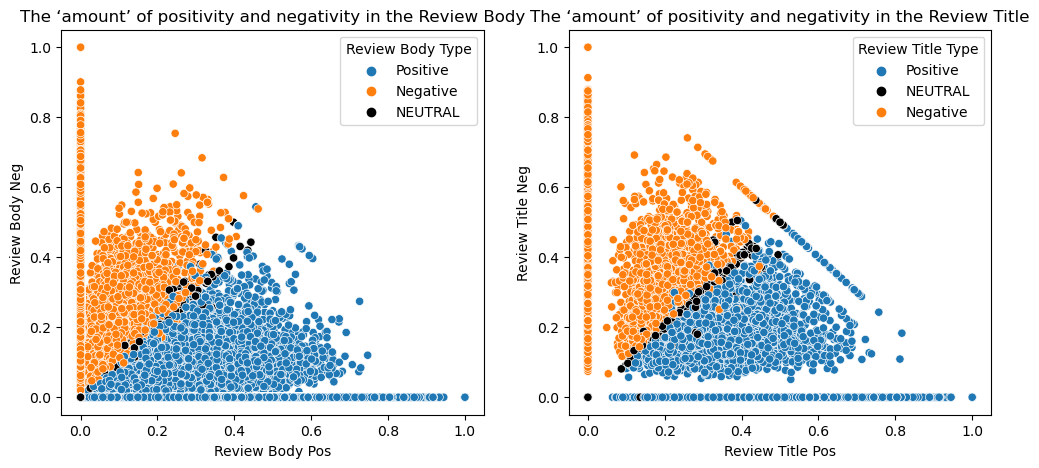

In [197]:
#In this exercise, I will use a CSV file containing reviews for different products. The link for the file is :
# https://drive.google.com/file/d/1NYdZoMJvBWuCejMX28pVRVfMyOe1GhnZ/view?usp=sharing
import numpy as np
import pandas as pd
import nltk

# Step 1: initialize NLTK and load the data
#download vader from nltk
#the data is doloaded in /Users/yongpengfu/nltk_data
#you can change the directory following https://www.nltk.org/data.html
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#creating an object of sentiment intensity analyzer
sia= SentimentIntensityAnalyzer()

# Let us now create a new column in our CSV file that stores the polarity scores of each review.
#creating new column scores using polarity scores function for Review Body
total_review['Review Body Scores']=total_review['Review Body'].apply(lambda body: sia.polarity_scores(str(body)))
total_review['Review Body Compound']=total_review['Review Body Scores'].apply(lambda score_dict:score_dict['compound'])
total_review['Review Body Pos']=total_review['Review Body Scores'].apply(lambda pos_dict:pos_dict['pos'])
total_review['Review Body Neg']=total_review['Review Body Scores'].apply(lambda neg_dict:neg_dict['neg'])
#We then create a new column named type, which indicates whether the review is pos, neg, or neutral.
# decide sentiment as positive, negative and neutral
total_review['Review Body Type']='NEUTRAL'
total_review.loc[total_review['Review Body Compound']>=0.05,'Review Body Type']='Positive'
total_review.loc[total_review['Review Body Compound']<=-0.05,'Review Body Type']='Negative'

#creating new column scores using polarity scores function for Review Title
total_review['Review Title Scores']=total_review['Review Title'].apply(lambda body: sia.polarity_scores(str(body)))
total_review['Review Title Compound']=total_review['Review Title Scores'].apply(lambda score_dict:score_dict['compound'])
total_review['Review Title Pos']=total_review['Review Title Scores'].apply(lambda pos_dict:pos_dict['pos'])
total_review['Review Title Neg']=total_review['Review Title Scores'].apply(lambda neg_dict:neg_dict['neg'])
#We then create a new column named type, which indicates whether the review is pos, neg, or neutral.
# decide sentiment as positive, negative and neutral
total_review['Review Title Type']='NEUTRAL'
total_review.loc[total_review['Review Title Compound']>=0.05,'Review Title Type']='Positive'
total_review.loc[total_review['Review Title Compound']<=-0.05,'Review Title Type']='Negative'

#Finally, we loop through the rows and count the total number of positive, negative, and neutral reviews.
print("The proporation for Review Body Type:\n")
print(total_review['Review Body Type'].value_counts())
print("The proporation for Review Title Type:\n")
print(total_review['Review Title Type'].value_counts())

total_review = total_review.drop(columns=['Review Body Scores','Review Title Scores'])
display(total_review.head(2))

#Show the ‘amount’ of positivity and negativity
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(1, 2,figsize=(12,5))
#to ensure same review type has the same color
palette ={"Positive": "C0", "Negative": "C1", "NEUTRAL": "k"}
sns.scatterplot(data=total_review, x="Review Body Pos", y="Review Body Neg", 
                hue="Review Body Type",ax=axes[0], palette=palette).set(title='The ‘amount’ of positivity and negativity in the Review Body')
sns.scatterplot(data=total_review, x="Review Title Pos", y="Review Title Neg", 
                hue="Review Title Type",ax=axes[1],palette=palette).set(title='The ‘amount’ of positivity and negativity in the Review Title')
plt.show()

#### Validation for VADER results
We noticed that VADER sometimes can give a wrong sentiment resuments. For example, the following 2 sentences are actually very positive, but the VADER results show them as Negative:

1. These phones are usually found in recording studios all over the world. They have a nice flat response and for this price they are an absolute steal!
2. Not for everyone, great for me

So we did a more thorough analysis on this by fitlering out reviews that actually have a high rating (like 5), but VADER results show them as Negative.

These phones are usually found in recording studios all over the world. They have a nice flat response and for this price they are an absolute steal! 
 Not for everyone, great for me

{'neg': 0.115, 'neu': 0.792, 'pos': 0.092, 'compound': -0.1759} 
 {'neg': 0.397, 'neu': 0.603, 'pos': 0.0, 'compound': -0.5096}

There are total 12714 that have 5 star reviews body but scored Negative in Review Body VADER results
There are total 2221 that have 5 star reviews title but scored Negative in Review Title VADER results

Conclusion: we cannot rely on VADER results to get the tone of a review. Probably a better way to categorize a review is using Review Rating (1-5).


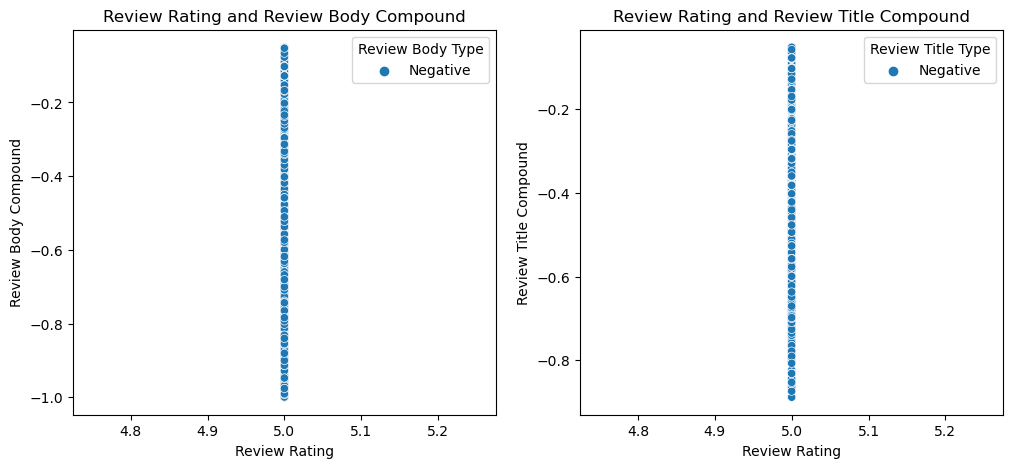

In [198]:
total_review['Review Rating'] = total_review['Review Rating'].astype(float)

Rating_Body_Type = total_review.loc[(total_review['Review Rating']==5.0) \
                                    & (total_review['Review Body Type']=='Negative')]
Rating_Title_Type = total_review.loc[(total_review['Review Rating']==5.0) \
                                     & (total_review['Review Title Type']=='Negative')]

print(Rating_Body_Type.iloc[0,4], '\n',Rating_Title_Type.iloc[0,2])
print()
print(sia.polarity_scores(rating_type.iloc[0,4]),'\n', sia.polarity_scores(Rating_Title_Type.iloc[0,2]))
print()
print(f'There are total {len(Rating_Body_Type)} that have 5 star reviews body but'+
          ' scored Negative in Review Body VADER results')
print(f'There are total {len(Rating_Title_Type)} that have 5 star reviews title but' +
          ' scored Negative in Review Title VADER results')
print()
print("Conclusion: we cannot rely on VADER results to get the tone of a review."+
      " Probably a better way to categorize a review is using Review Rating (1-5).")

#Show all the reviews that have 5 star rating but scored Negative in VADER results
fig, axes = plt.subplots(1, 2,figsize=(12,5))
sns.scatterplot(data=Rating_Body_Type, x="Review Rating", y="Review Body Compound",
                hue = "Review Body Type", ax=axes[0]).set(title='Review Rating and Review Body Compound')
sns.scatterplot(data=Rating_Title_Type, x="Review Rating", y="Review Title Compound",
                hue = "Review Title Type", ax=axes[1]).set(title='Review Rating and Review Title Compound')
plt.show()

### How To Perform Sentiment Analysis in Python 3 Using the Natural Language Toolkit (NLTK)
Follow tutorial from https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk

A large amount of data that is generated today is unstructured, which requires processing to generate insights. Some examples of unstructured data are news articles, posts on social media, and search history. The process of analyzing natural language and making sense out of it falls under the field of Natural Language Processing (NLP). Sentiment analysis is a common NLP task, which involves classifying texts or parts of texts into a pre-defined sentiment. You will use the Natural Language Toolkit (NLTK), a commonly used NLP library in Python, to analyze textual data.

In this tutorial, you will prepare a dataset of sample tweets from the NLTK package for NLP with different data cleaning methods. Once the dataset is ready for processing, you will train a model on pre-classified tweets and use the model to classify the sample tweets into negative and positives sentiments.

This article assumes that you are familiar with the basics of Python (see our How To Code in Python 3 series), primarily the use of data structures, classes, and methods. The tutorial assumes that you have no background in NLP and nltk, although some knowledge on it is an added advantage.



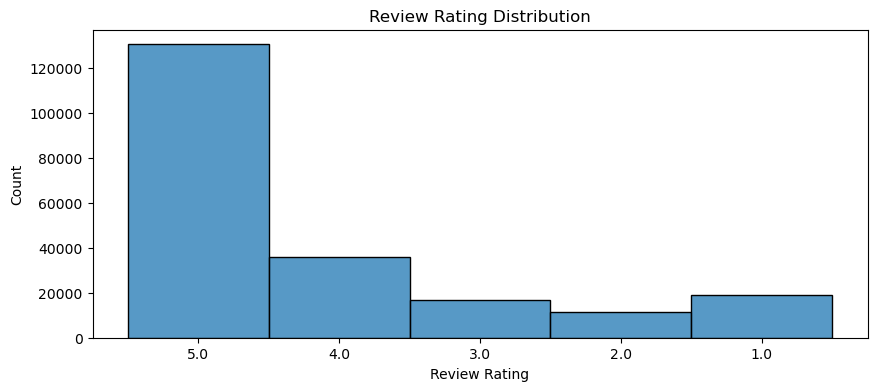

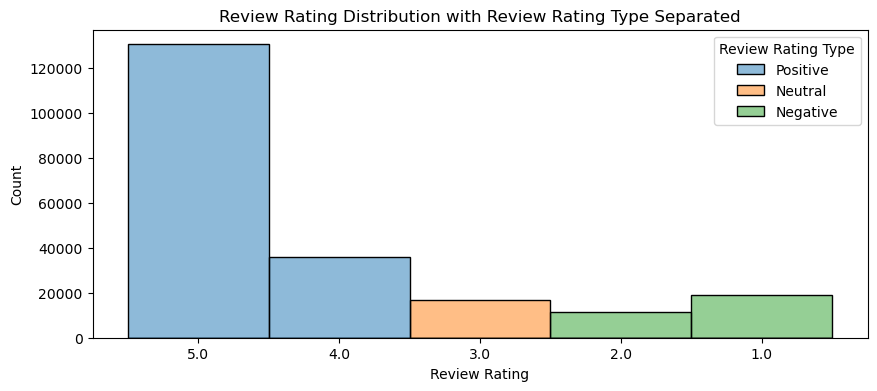

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

'''
Based on previous VADER results, we conclude that we cannot rely on VADER results to get the tone of a review. 
Probably a better way to categorize a review is using Review Rating (1-5).
'''
fig, ax = plt.subplots(figsize=(10,4))
total_review['Review Rating'] = total_review['Review Rating'].astype(float).astype(str)
sns.histplot(data=total_review, x="Review Rating",ax = ax).set(title='Review Rating Distribution')
plt.show()

'''
From the above distribution plot, we see there are 5 ratings associated with each review.
After investigating some of reviews with different rating using 
`total_review.loc[total_review['Review Rating'] =="2.0"].iloc[5,4]`,
we roughly will categorize the review as follows:

5.0, 4.0 >>>> Positive
3.0 >>> Neutral
2.0, 1.0 >>> Negative
'''
total_review['Review Rating'] = total_review['Review Rating'].astype(float).astype(str)
conditions = {"5.0":"Positive", "4.0":"Positive","3.0":"Neutral", "2.0":"Negative", "1.0":"Negative"}
total_review['Review Rating Type'] = total_review['Review Rating'].map(conditions)
# total_review.head(4)

fig, ax = plt.subplots(figsize=(10,4))
sns.histplot(data=total_review, x="Review Rating",ax = ax, 
             hue = "Review Rating Type").set(title='Review Rating Distribution with Review Rating Type Separated')
plt.show()

In [4]:
import numpy as np
import pandas as pd
import nltk
from nltk import word_tokenize #use classical tokenize https://www.nltk.org/
import re, string

#Step 1 - Load our data. We only need `Review Title`, `Review Body`, and `Review Rating Type`
total_review_rating_type = total_review.loc[:,['Review Title', 'Review Body','Review Rating Type']]

#Step 2 — Tokenizing the Data and Remove noice
# Convert to lowercase, and remove stop words
'''
A question, why is not a stopword? 
https://datascience.stackexchange.com/questions/15765/nlp-why-is-not-a-stop-word
https://stackoverflow.com/questions/62051187/why-in-nltk-not-is-considered-as-stopping-word-in-english
'''
'''
Language in its original form cannot be accurately processed by a machine, 
so you need to process the language to make it easier for the machine to understand. 
The first part of making sense of the data is through a process called tokenization, 
or splitting strings into smaller parts called tokens.

A token is a sequence of characters in text that serves as a unit. 
Based on how you create the tokens, they may consist of words, emoticons, hashtags, links, 
or even individual characters. A basic way of breaking language into tokens is by splitting the text 
based on whitespace and punctuation.
'''

'''
In addition to this, you will also remove stop words using a built-in set of stop words in NLTK, 
which needs to be downloaded separately.
'''
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

'''
Words have different forms—for instance, “ran”, “runs”, and “running” are various forms of the same verb, 
“run”. Depending on the requirement of your analysis, 
all of these versions may need to be converted to the same form, “run”. 
Normalization in NLP is the process of converting a word to its canonical form.
'''
'''
wordnet is a lexical database for the English language that helps the script determine the base word. 
You need the averaged_perceptron_tagger resource to determine the context of a word in a sentence.
'''
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
'''
Once downloaded, you are almost ready to use the lemmatizer. Before running a lemmatizer, 
you need to determine the context for each word in your text. 
This is achieved by a tagging algorithm, which assesses the relative position of a word in a sentence. 
'''
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

'''
From the list of tags, here is the list of the most common items and their meaning:

NNP: Noun, proper, singular
NN: Noun, common, singular or mass
IN: Preposition or conjunction, subordinating
VBG: Verb, gerund or present participle
VBN: Verb, past participle

see more in https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

In general, if a tag starts with NN, the word is a noun and if it stars with VB, the word is a verb. 
'''

#Refer https://jackmckew.dev/sentiment-analysis-text-cleaning-in-python-with-vader.html
def remove_noise(review_tokens, stopwords = ()):
    cleaned_tokens = []
    
    for token, tag in pos_tag(review_tokens):
        #remove link
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        #remove any @text
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)
        #If we still have string left
        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

total_review_rating_type['Review Body Tokenized'] = total_review_rating_type\
    .apply(lambda row: remove_noise(word_tokenize(row['Review Body']), stop_words), axis=1)
# total_review_rating_type.to_csv("/Users/yongpengfu/Desktop/total_review_rating_type_without_stopwords.csv")
#to show what is before and after removing noice
total_review_rating_type.iloc[0,1], total_review_rating_type.iloc[0,3]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yongpengfu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yongpengfu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yongpengfu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


("These are just superb for audio quality. You'll hear base and treble that you won't via bluetooth or lower quality. Even my Bose headphones can't match these for sound.Good points are well built, long cable and decent build quality. Also the audio which as noted above is superb.Bad points are they're not the most comfortable if you wear for prolonged periods of time.",
 ['superb',
  'audio',
  'quality',
  "'ll",
  'hear',
  'base',
  'treble',
  'wo',
  "n't",
  'via',
  'bluetooth',
  'low',
  'quality',
  'even',
  'bose',
  'headphone',
  'ca',
  "n't",
  'match',
  'sound.good',
  'point',
  'well',
  'build',
  'long',
  'cable',
  'decent',
  'build',
  'quality',
  'also',
  'audio',
  'note',
  'superb.bad',
  'point',
  "'re",
  'comfortable',
  'wear',
  'prolonged',
  'period',
  'time'])

In [5]:
#Step 3 — Determining Word Density
'''
The most basic form of analysis on textual data is to take out the word frequency. 
A single tweet is too small of an entity to find out the distribution of words, hence, 
the analysis of the frequency of words would be done on all positive tweets.
'''
def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

all_pos_words = get_all_words(total_review_rating_type['Review Body Tokenized'])

'''
Now that you have compiled all words in the sample of tweets, 
you can find out which are the most common words using the FreqDist class of NLTK. 
'''
from nltk import FreqDist
'''
The .most_common() method lists the words which occur most frequently in the data. 
From this data, you can see that emoticon entities form some of the most common parts of positive tweets
'''
freq_dist_pos = FreqDist(all_pos_words)
print(freq_dist_pos.most_common(10))

[('sound', 80619), ('good', 76221), ('quality', 56455), ('de', 51767), ('headphone', 50433), ('great', 46150), ('use', 45170), ('la', 43021), ('ear', 39344), ('e', 39208)]


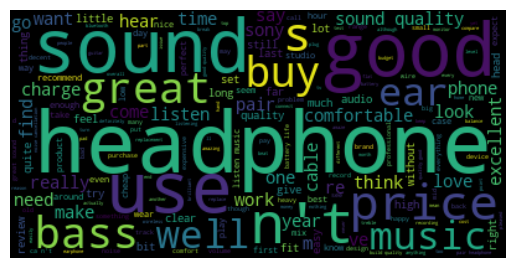

In [12]:
'''
Let's build a word cloud of all the reviews first before we filter out for just top scorers i
n different categories and see what the most frequently mentioned words are. 
We define a function for plotting the word cloud to make it easy as possible to change out the source data.
'''
total_review_rating_type['Review Body Cleaned Review'] = total_review_rating_type['Review Body Tokenized']\
    .apply(lambda x: ' '.join(x))

def plot_wordcloud(series, top_n):
    from wordcloud import WordCloud
    wordcloud = WordCloud().generate(' '.join(series[0:top_n].astype(str)))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
#Plot the top 500 Positive reviews
plot_wordcloud(total_review_rating_type.loc[total_review_rating_type['Review Rating Type']=="Positive",
                                            'Review Body Cleaned Review'], top_n = 500)

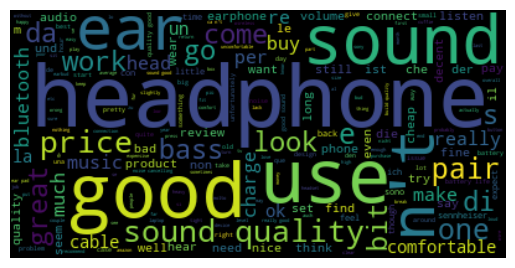

In [13]:
#Plot the top 500 Neutral reviews
plot_wordcloud(total_review_rating_type.loc[total_review_rating_type['Review Rating Type']=="Neutral",
                                            'Review Body Cleaned Review'], top_n = 500)

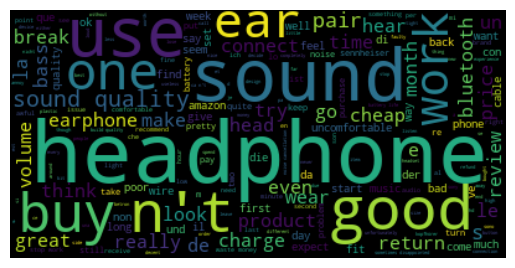

In [14]:
#Plot the top 500 Negative reviews
plot_wordcloud(total_review_rating_type.loc[total_review_rating_type['Review Rating Type']=="Negative",
                                            'Review Body Cleaned Review'], top_n = 500)

In [18]:
# Step 4 — Preparing Data for the Model
'''
Sentiment analysis is a process of identifying an attitude of the author on a topic that is being written about. 
You will create a training data set to train a model. 
It is a supervised learning machine learning process, 
which requires you to associate each dataset with a “sentiment” for training. 
In this tutorial, your model will use the “positive” and “negative” sentiments.
'''

'''
First, you will prepare the data to be fed into the model. 
You will use the Naive Bayes classifier in NLTK to perform the modeling exercise. 
Notice that the model requires not just a list of words in a tweet, 
but a Python dictionary with words as keys and True as values. 
The following function makes a generator function to change the format of the cleaned data.
'''
'''
Add the following code to convert the tweets from a list of cleaned tokens to dictionaries with keys 
as the tokens and True as values. The corresponding dictionaries are stored in positive_tokens_for_model and 
negative_tokens_for_model.
'''
def get_reviews_for_model(cleaned_tokens_list):
    for review_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in review_tokens)

positive_tokens_for_model = get_reviews_for_model(total_review_rating_type.loc[total_review_rating_type['Review Rating Type']=="Positive",
                                            'Review Body Tokenized'].to_list())
neutral_tokens_for_model = get_reviews_for_model(total_review_rating_type.loc[total_review_rating_type['Review Rating Type']=="Neutral",
                                            'Review Body Tokenized'].to_list())
negative_tokens_for_model = get_reviews_for_model(total_review_rating_type.loc[total_review_rating_type['Review Rating Type']=="Negative",
                                            'Review Body Tokenized'].to_list())

'''
This code attaches a Positive or Negative label to each tweet. 
It then creates a dataset by joining the positive and negative tweets.

By default, the data contains all positive tweets followed by all negative tweets in sequence.
When training the model, you should provide a sample of your data that does not contain any bias. 
To avoid bias, you’ve added code to randomly arrange the data using the .shuffle() method of random.

Finally, the code splits the shuffled data into a ratio of 70:30 for training and testing, respectively. 
Since the number of tweets is 10000, you can use the first 7000 tweets from the shuffled dataset for training 
the model and the final 3000 for testing the model.

In this step, you converted the cleaned tokens to a dictionary form, randomly shuffled the dataset, 
and split it into training and testing data.
'''
import random

positive_dataset = [(tweet_dict, "Positive")
                     for tweet_dict in positive_tokens_for_model]

neutral_dataset = [(tweet_dict, "Negative")
                     for tweet_dict in neutral_tokens_for_model]

negative_dataset = [(tweet_dict, "Negative")
                     for tweet_dict in negative_tokens_for_model]

dataset = positive_dataset + neutral_dataset + negative_dataset

random.shuffle(dataset)

train_data = dataset[:7000]
test_data = dataset[7000:]
train_data[0], test_data[0]

(({'sin': True,
   'duda': True,
   'volvería': True,
   'comprarlos': True,
   'se': True,
   'oyen': True,
   'bien': True,
   'funcionan': True,
   'muy': True,
   'dura': True,
   'muchísimo': True,
   'la': True,
   'batería': True},
  'Positive'),
 ({'great': True, 'product': True}, 'Positive'))

In [21]:
#Step 5 — Building and Testing the Model
'''
Finally, you can use the NaiveBayesClassifier class to build the model. 
Use the .train() method to train the model and the .accuracy() method to test the model on the testing data.
'''

'''
Accuracy is defined as the percentage of tweets in the testing dataset for which the model was correctly able to predict the sentiment.
A 99.5% accuracy on the test set is pretty good.

In the table that shows the most informative features, 
every row in the output shows the ratio of occurrence of a token in positive and negative tagged tweets in the training dataset. 
The first row in the data signifies that in all tweets containing the token :(, the ratio of negative to positives tweets was 2085.6 to 1. 
Interestingly, it seems that there was one token with :( in the positive datasets. You can see that the top two 
discriminating items in the text are the emoticons. Further, 
words such as sad lead to negative sentiments, whereas welcome and glad are associated with positive sentiments.
'''
from nltk import classify
from nltk import NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(train_data)

print("Accuracy is:", classify.accuracy(classifier, test_data))
print(classifier.show_most_informative_features(10))

'''
Next, you can check how the model performs on random review:
'''
custom_review = "I ordered just once from TerribleCo, they screwed up, never used the app again."
custom_tokens = remove_noise(word_tokenize(custom_review), stop_words)
print(classifier.classify(dict([token, True] for token in custom_tokens)))


Accuracy is: 0.7446747822051187
Most Informative Features
                terrible = True           Negati : Positi =     23.5 : 1.0
                  repair = True           Negati : Positi =     21.8 : 1.0
                  window = True           Negati : Positi =     20.0 : 1.0
                 stopped = True           Negati : Positi =     18.6 : 1.0
                  defekt = True           Negati : Positi =     17.2 : 1.0
                 monaten = True           Negati : Positi =     17.2 : 1.0
                  rechte = True           Negati : Positi =     17.2 : 1.0
                   worst = True           Negati : Positi =     17.2 : 1.0
           disappointing = True           Negati : Positi =     15.9 : 1.0
                  refund = True           Negati : Positi =     15.6 : 1.0
None
Negative
